In [ ]:
# ------------------ Matan + Omer XGBoost model with GPU ------------------ #
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
import numpy as np
import pandas as pd
import scipy.stats

# GPU setup
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError:
        pass

# Fixed best parameters per bin (from your output)
BIN_PARAMS = {
    '0-10K':     {'subsample': 0.7, 'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.01, 'colsample_bytree': 1.0},
    '10K-100K':  {'subsample': 0.7, 'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.01, 'colsample_bytree': 0.7},
    '100K-1M':   {'subsample': 0.7, 'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.01, 'colsample_bytree': 0.7},
    '1M-10M':    {'subsample': 0.7, 'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.01, 'colsample_bytree': 0.7},
    '10M+':      {'subsample': 1.0, 'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 1.0}
}

# Will hold the trained models per bin
trained_models = {}

def process_bin(df, bin_label):
    features = ['log_followers', 'sentiment', 'tweet_length', 'hashtag_count']

    group_df = df[df['popularity_bin'] == bin_label].copy()
    group_df = group_df[features + ['number_of_likes']].dropna()
    group_df = group_df[np.isfinite(group_df['number_of_likes'])]

    if len(group_df) < 50:
        print(f"⚠️ Skipping bin '{bin_label}' due to insufficient data ({len(group_df)} rows).")
        return None

    print(f"✅ {bin_label} - before removing outliers: {len(group_df)} rows")

    # Remove outliers using IQR
    Q1 = group_df['number_of_likes'].quantile(0.25)
    Q3 = group_df['number_of_likes'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    group_df = group_df[(group_df['number_of_likes'] >= lower_bound) & (group_df['number_of_likes'] <= upper_bound)]

    print(f"✅ {bin_label} - after removing outliers: {len(group_df)} rows")

    X = group_df[features]
    y = group_df['number_of_likes']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    params = BIN_PARAMS[bin_label]

    xgb_model = XGBRegressor(
        objective='reg:squarederror',
        tree_method='gpu_hist',
        device='cuda:0',
        random_state=42,
        **params
    )

    xgb_model.fit(X_train, y_train)
    y_pred = xgb_model.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Calculate p-value (simple t-test on residuals as a quick approximation)
    residuals = y_test - y_pred
    t_stat, p_value = scipy.stats.ttest_1samp(residuals, 0)

    print(f"✅ {bin_label} - Params: {params}")
    print(f"✅ {bin_label} - RMSE: {rmse:.2f}, MAE: {mae:.2f}, R²: {r2:.4f}, p-value: {p_value:.4e}")

    # Save model to dictionary for later use
    trained_models[bin_label] = xgb_model

    return {
        'bin': bin_label,
        'rmse': rmse,
        'mae': mae,
        'r2': r2,
        'p_value': p_value,
        'model': xgb_model
    }

# Load data
df = pd.read_csv('/content/dataset_cleaned.csv')

# Add features
df['log_followers'] = np.log1p(df['followers_count'])

# Create bins
bins = [0, 1e4, 1e5, 1e6, 1e7, np.inf]
labels = ['0-10K', '10K-100K', '100K-1M', '1M-10M', '10M+']
df['popularity_bin'] = pd.cut(df['followers_count'], bins=bins, labels=labels, right=False)

# Run process for each bin
results = []
for label in labels:
    result = process_bin(df, label)
    if result:
        results.append(result)

# Optionally convert results to DataFrame
results_df = pd.DataFrame(results)
print("\n📊 Summary of Results:")
print(results_df[['bin', 'rmse', 'mae', 'r2', 'p_value']])

# Function to predict likes given (followers_count, sentiment)
def predict_likes_xgb(followers_count, sentiment, tweet_length=100, hashtag_count=0):
    # Determine bin
    bin_edges = [0, 1e4, 1e5, 1e6, 1e7, float('inf')]
    bin_labels = ['0-10K', '10K-100K', '100K-1M', '1M-10M', '10M+']
    bin_label = None
    for i in range(len(bin_edges) - 1):
        if bin_edges[i] <= followers_count < bin_edges[i + 1]:
            bin_label = bin_labels[i]
            break

    if bin_label is None or bin_label not in trained_models:
        raise ValueError(f"Followers count {followers_count} falls outside known bins or model not trained for this bin.")

    model = trained_models[bin_label]

    # Prepare input features
    log_followers = np.log1p(followers_count)
    input_features = np.array([[log_followers, sentiment, tweet_length, hashtag_count]])

    # Predict
    predicted_likes = model.predict(input_features)[0]
    return predicted_likes

✅ 0-10K - before removing outliers: 125488 rows
✅ 0-10K - after removing outliers: 108039 rows
✅ 0-10K - Params: {'subsample': 0.7, 'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.01, 'colsample_bytree': 1.0}
✅ 0-10K - RMSE: 0.61, MAE: 0.50, R²: 0.0290, p-value: 1.7301e-01
✅ 10K-100K - before removing outliers: 7308 rows
✅ 10K-100K - after removing outliers: 6186 rows
✅ 10K-100K - Params: {'subsample': 0.7, 'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.01, 'colsample_bytree': 0.7}
✅ 10K-100K - RMSE: 7.44, MAE: 5.34, R²: 0.0349, p-value: 3.1781e-01
✅ 100K-1M - before removing outliers: 1224 rows
✅ 100K-1M - after removing outliers: 1024 rows
✅ 100K-1M - Params: {'subsample': 0.7, 'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.01, 'colsample_bytree': 0.7}
✅ 100K-1M - RMSE: 155.84, MAE: 109.93, R²: 0.1429, p-value: 5.6297e-01
✅ 1M-10M - before removing outliers: 153 rows
✅ 1M-10M - after removing outliers: 132 rows
✅ 1M-10M - Params: {'subsample': 0.7, 'n_estima

In [ ]:
#------------- Idan's Decision Tree --------------#
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Load the dataset
Data = pd.read_csv("/content/dataset_cleaned.csv")
df = Data.copy()

# Clean the data
df_clean = df.dropna(subset=['followers_count', 'number_of_likes'])

# Manual group assignment
def assign_group(follower_count):
    if 1 <= follower_count <= 10:
        return 'Group_0'
    elif 11 <= follower_count <= 106:
        return 'Group_1'
    elif 107 <= follower_count <= 1105:
        return 'Group_2'
    elif 1106 <= follower_count <= 11428:
        return 'Group_3'
    elif 11429 <= follower_count <= 118159:
        return 'Group_4'
    elif 118160 <= follower_count <= 1221693:
        return 'Group_5'
    elif 1221694 <= follower_count <= 12631526:
        return 'Group_6'
    elif 12631527 <= follower_count <= 60000000:
        return 'Group_7a'
    elif 60000001 <= follower_count <= 80000000:
        return 'Group_7b'
    elif 80000001 <= follower_count <=85000000:
        return 'Group_7c1'
    elif 85000000 <= follower_count <= 130601913:
        return 'Group_7c2'
    else:
        return 'Group_7c2'  # Default for outliers

df_clean['group'] = df_clean['followers_count'].apply(assign_group)

# Define all group names
all_group_names = [
    'Group_0', 'Group_1', 'Group_2', 'Group_3', 'Group_4',
    'Group_5', 'Group_6', 'Group_7a', 'Group_7b', 'Group_7c1', 'Group_7c2'
]

# Dict to hold trained DT models per group_id
trained_dt_models = {}

# Functions
def apply_optimal_strategy(df_group, group_id):
    """Apply the predetermined optimal strategy for each group"""
    df_processed = df_group.copy()

    strategy_map = {
        'Group_0': 'log_transform',
        'Group_1': 'remove_extreme',
        'Group_2': 'capped_95th',
        'Group_3': 'capped_95th',
        'Group_4': 'original',
        'Group_5': 'original',
        'Group_6': 'log_transform',
        'Group_7a': 'capped_95th',
        'Group_7b': 'log_transform',
        'Group_7c1': 'log_transform',
        'Group_7c2': 'log_transform'
    }

    strategy = strategy_map.get(group_id, 'original')

    if strategy == 'log_transform':
        df_processed['number_of_likes_log'] = np.log1p(df_processed['number_of_likes'])
        target_col = 'number_of_likes_log'
    elif strategy == 'remove_extreme':
        p99 = df_processed['number_of_likes'].quantile(0.99)
        df_processed = df_processed[df_processed['number_of_likes'] <= p99].copy()
        target_col = 'number_of_likes'
    elif strategy == 'capped_95th':
        p95 = df_processed['number_of_likes'].quantile(0.95)
        df_processed['number_of_likes'] = df_processed['number_of_likes'].clip(upper=p95)
        target_col = 'number_of_likes'
    else:
        target_col = 'number_of_likes'

    return df_processed, target_col, strategy

def create_features_for_modeling(df_group):
    """Create features for the regression model"""
    features_df = df_group.copy()

    # Add useful features
    features_df['log_followers'] = np.log1p(features_df['followers_count'])
    features_df['followers_squared'] = features_df['followers_count'] ** 2
    features_df['followers_sqrt'] = np.sqrt(features_df['followers_count'])

    # Statistical feature
    if features_df['followers_count'].std() > 0:
        features_df['followers_zscore'] = (
            (features_df['followers_count'] - features_df['followers_count'].mean())
            / features_df['followers_count'].std()
        )
    else:
        features_df['followers_zscore'] = 0

    features_df = features_df.replace([np.inf, -np.inf], np.nan).fillna(0)
    return features_df

def train_decision_tree_model(df_group, group_id):
    """Train model with predetermined optimal strategy"""
    if len(df_group) < 20:
        return None

    df_processed, target_col, strategy = apply_optimal_strategy(df_group, group_id)
    features_df = create_features_for_modeling(df_processed)

    feature_columns = ['followers_count', 'sentiment']
    X = features_df[feature_columns]
    y = features_df[target_col]

    if y.std() == 0:
        return None

    test_size = min(0.3, max(0.1, 100/len(X)))
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

    dt_model = DecisionTreeRegressor(
        max_depth=15,
        min_samples_split=max(5, len(X_train)//100),
        min_samples_leaf=max(2, len(X_train)//200),
        random_state=42,
        max_features='sqrt' if len(feature_columns) > 1 else None
    )

    try:
        dt_model.fit(X_train, y_train)
        y_pred_test = dt_model.predict(X_test)

        test_mae = mean_absolute_error(y_test, y_pred_test)
        test_mse = mean_squared_error(y_test, y_pred_test)
        test_rmse = np.sqrt(test_mse)
        test_r2 = r2_score(y_test, y_pred_test)

        if len(y_test) > 2:
            correlation, p_value = stats.pearsonr(y_test, y_pred_test)
        else:
            correlation, p_value = 0, 1

        # Save model to dict
        trained_dt_models[group_id] = {
            'model': dt_model,
            'target_col': target_col,
            'strategy': strategy,
            'feature_columns': feature_columns
        }

        return {
            'strategy': strategy,
            'sample_size': len(df_processed),
            'test_mae': test_mae,
            'test_mse': test_mse,
            'test_rmse': test_rmse,
            'test_r2': test_r2,
            'correlation': correlation,
            'p_value': p_value,
            'target_mean': y.mean(),
            'target_std': y.std(),
            'model': dt_model,
            'feature_columns': feature_columns,
            'target_col': target_col
        }

    except Exception as e:
        return None

# Main execution
all_results = []
for group_name in all_group_names:
    group_data = df_clean[df_clean['group'] == group_name]

    if len(group_data) > 0:
        if '7' in group_name and len(group_name) > 7:
            group_display = group_name.split('_')[1]
        else:
            group_display = int(group_name.split('_')[1])

        result = train_decision_tree_model(group_data, group_display)
        if result:
            result['group_id'] = group_display
        all_results.append(result)
    else:
        all_results.append(None)

# Filter out None results
final_results = [r for r in all_results if r is not None]

# 📢 Prediction function
def predict_likes_dt(followers_count, sentiment):
    # Determine group
    group_name = assign_group(followers_count)

    if '7' in group_name and len(group_name) > 7:
        group_id = group_name.split('_')[1]
    else:
        group_id = int(group_name.split('_')[1])

    # Check if model exists
    if group_id not in trained_dt_models:
        print(f"❌ No trained model for group {group_id}. Cannot predict.")
        return None

    model_info = trained_dt_models[group_id]
    dt_model = model_info['model']
    strategy = model_info['strategy']

    # Prepare input features
    input_features = np.array([[followers_count, sentiment]])
    predicted_value = dt_model.predict(input_features)[0]

    # Inverse transform if needed
    if strategy == 'log_transform':
        predicted_likes = np.expm1(predicted_value)
    else:
        predicted_likes = predicted_value

    # Output
    # print(f"📢 [DT] Prediction for followers={followers_count} (group={group_id}), sentiment={sentiment}: "
    #       f"{predicted_likes:.2f} likes (strategy: {strategy})")
    return predicted_likes


In [ ]:
print("🚀 OPTION 1: CuML Random Forest (True GPU Acceleration)")
print("Note: Requires RAPIDS CuML installation")

def setup_cuml_random_forest():
    """
    CuML Random Forest - TRUE GPU Random Forest
    Installation: !pip install cuml-cu11 (or appropriate CUDA version)
    """
    try:
        from cuml.ensemble import RandomForestRegressor as CuRandomForestRegressor
        from cuml import train_test_split as cu_train_test_split
        import cudf

        print("✅ CuML available - Using TRUE GPU Random Forest")

        # Load data with GPU DataFrames
        df = cudf.read_csv("/content/dataset_cleaned.csv")
        df_clean = df.dropna(subset=['followers_count', 'sentiment', 'number_of_likes', 'tweet_length', 'hashtag_count'])
        df_clean = df_clean[(df_clean['followers_count'] > 0) & (df_clean['number_of_likes'] >= 0)]

        # Add log_followers on GPU
        df_clean['log_followers'] = cudf.Series(np.log1p(df_clean['followers_count'].to_pandas().values))

        # Prepare features and target (all on GPU)
        features = ['log_followers', 'sentiment', 'tweet_length', 'hashtag_count']
        X = df_clean[features]
        y = df_clean['number_of_likes']

        # GPU train/test split
        X_train, X_test, y_train, y_test = cu_train_test_split(X, y, test_size=0.2, random_state=42)

        # Train GPU Random Forest
        gpu_rf_model = CuRandomForestRegressor(
            n_estimators=300,
            max_depth=12,
            min_samples_leaf=5,
            random_state=42,
            n_streams=1  # GPU streams for parallel processing
        )

        print("Training CuML Random Forest on GPU...")
        gpu_rf_model.fit(X_train, y_train)

        # GPU predictions
        y_pred = gpu_rf_model.predict(X_test)

        # Convert back to pandas for metrics
        y_test_cpu = y_test.to_pandas()
        y_pred_cpu = y_pred.to_pandas()

        r2 = r2_score(y_test_cpu, y_pred_cpu)
        mae = mean_absolute_error(y_test_cpu, y_pred_cpu)

        print(f"CuML GPU Random Forest - R²: {r2:.4f}, MAE: {mae:.2f}")

        # GPU prediction function
        def predict_likes_rf(followers_count, sentiment, tweet_length=100, hashtag_count=0):
            log_followers = np.log1p(followers_count)
            # Create GPU DataFrame for prediction
            input_df = cudf.DataFrame({
                'log_followers': [log_followers],
                'sentiment': [sentiment],
                'tweet_length': [tweet_length],
                'hashtag_count': [hashtag_count]
            })
            prediction = gpu_rf_model.predict(input_df)
            return float(prediction.to_pandas().iloc[0])

        return gpu_rf_model, predict_likes_cuml_rf

    except ImportError:
        print("❌ CuML not available. Install with: !pip install cuml-cu11")
        return None, None

🚀 OPTION 1: CuML Random Forest (True GPU Acceleration)
Note: Requires RAPIDS CuML installation


# FINAL METAMODEL



In [ ]:
# GPU initialization
import torch
import joblib
import os
import time
import timeit
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(0) if torch.cuda.is_available() else None

#============================= **meta-model** (ex: LinearRegression) to learn best weights for the 2 models ============================#

import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy import stats
from sklearn.model_selection import train_test_split

# Load CSV
df_eval = pd.read_csv('/content/dataset_cleaned.csv')  # replace with your CSV path

# Drop rows with missing
df_eval = df_eval.dropna(subset=['followers_count', 'tweet_length', 'hashtag_count', 'number_of_likes', 'sentiment'])

# Debug your actual dataset
print("Checking your actual dataset for problematic values...")

# Check for problematic values in your data
print(f"\nDataset info:")
print(f"Total rows: {len(df_eval)}")
print(f"Followers range: {df_eval['followers_count'].min()} to {df_eval['followers_count'].max()}")
print(f"Sentiment range: {df_eval['sentiment'].min()} to {df_eval['sentiment'].max()}")


# Collect predictions
pred_dt = []
pred_xgb = []
true_likes = []


for i, (_, row) in enumerate(df_eval.iterrows()):
    followers_count = row['followers_count']
    sentiment = row['sentiment']
    tweet_length = row['tweet_length']
    hashtag_count = row['hashtag_count']
    likes = row['number_of_likes']

    # Get predictions
    pred_dt_val = predict_likes_dt(followers_count, sentiment)
    pred_xgb_val = predict_likes_xgb(followers_count, sentiment, tweet_length, hashtag_count)

    # Only save if both predictions are valid (not None and not NaN)
    if (pred_dt_val is not None and pred_xgb_val is not None and
        not np.isnan(pred_dt_val) and not np.isnan(pred_xgb_val)):
        pred_dt.append(pred_dt_val)
        pred_xgb.append(pred_xgb_val)
        true_likes.append(likes)

    # Print progress every 1000 rows
    if (i + 1) % 1000 == 0:
        print(f"Processed {i + 1} rows...")

# Create meta-dataset
print(f"Valid predictions: {len(pred_dt)} out of {len(df_eval)} rows")
X_meta = np.column_stack([pred_dt, pred_xgb])
y_meta = np.array(true_likes)

# Split meta-train / meta-test - PRESERVE INDICES
X_train, X_test, y_train, y_test, train_idx, test_idx = train_test_split(
    X_meta, y_meta, range(len(X_meta)), test_size=0.2, random_state=42
)

# Train meta-model
meta_model = LinearRegression()
train_start = timeit.default_timer()
meta_model.fit(X_train, y_train)
Train_end = timeit.default_timer()
print(f"train time took {(Train_end-train_start):.6f}")
train_time = time.time() - train_start

# Predict
inference_start = time.time()
y_pred = meta_model.predict(X_test)
inference_time = time.time() - inference_start
inference_time_per_sample = (inference_time / len(X_test)) * 1000  # ms per sample

# Comprehensive Metrics and Statistics
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error
from scipy.stats import normaltest, shapiro, anderson

# Basic metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred) * 100
r2 = r2_score(y_test, y_pred)
adjusted_r2 = 1 - (1 - r2) * (len(y_test) - 1) / (len(y_test) - X_test.shape[1] - 1)

# Correlation analysis
correlation, p_value = stats.pearsonr(y_test, y_pred)
spearman_corr, spearman_p = stats.spearmanr(y_test, y_pred)
kendall_corr, kendall_p = stats.kendalltau(y_test, y_pred)

# Residual analysis
residuals = y_test - y_pred
residuals_std = residuals / np.std(residuals)
mean_residual = np.mean(residuals)
std_residual = np.std(residuals)

# Statistical tests
shapiro_stat, shapiro_p = shapiro(residuals[:5000] if len(residuals) > 5000 else residuals)
durbin_watson = np.sum(np.diff(residuals)**2) / np.sum(residuals**2)

# FIXED: Individual model performance on test set using preserved indices
# Get the original data rows corresponding to test indices
test_rows = df_eval.iloc[test_idx]

# Save meta-model
model_filename = 'meta_model_linear.pkl'
joblib.dump(meta_model, model_filename)
model_size_bytes = os.path.getsize(model_filename)
model_size_mb = model_size_bytes / (1024 * 1024)

# Print comprehensive results
print("\n" + "="*60)
print("           META-MODEL COMPREHENSIVE ANALYSIS")
print("="*60)

print(f"\n📊 DATASET STATISTICS:")
print(f"   Total rows processed: {len(df_eval):,}")
print(f"   Valid predictions: {len(pred_dt):,} ({len(pred_dt)/len(df_eval)*100:.1f}%)")
print(f"   Training samples: {len(X_train):,}")
print(f"   Test samples: {len(X_test):,}")

print(f"\n🎯 META-MODEL PERFORMANCE:")
print(f"   RMSE: {rmse:,.2f}")
print(f"   MAE: {mae:,.2f}")
print(f"   MAPE: {mape:.2f}%")
print(f"   R²: {r2:.4f}")
print(f"   Adjusted R²: {adjusted_r2:.4f}")

print(f"\n📈 CORRELATION ANALYSIS:")
print(f"   Pearson correlation: {correlation:.4f} (p-value: {p_value:.2e})")
print(f"   Spearman correlation: {spearman_corr:.4f} (p-value: {spearman_p:.2e})")
print(f"   Kendall's tau: {kendall_corr:.4f} (p-value: {kendall_p:.2e})")

print(f"\n🔍 RESIDUAL ANALYSIS:")
print(f"   Mean residual: {mean_residual:.4f}")
print(f"   Std residual: {std_residual:.2f}")
print(f"   Residual normality (Shapiro-Wilk): p-value = {shapiro_p:.2e}")
print(f"   Durbin-Watson statistic: {durbin_watson:.4f}")

# if any(valid_indices):
#     print(f"\n⚖️ INDIVIDUAL MODEL COMPARISON:")
#     print(f"   Decision Tree - RMSE: {dt_rmse:,.2f}, R²: {dt_r2:.4f}")
#     print(f"   XGBoost - RMSE: {xgb_rmse:,.2f}, R²: {xgb_r2:.4f}")
#     print(f"   Meta-model improvement over DT: {((dt_rmse - rmse)/dt_rmse)*100:.1f}%")
#     print(f"   Meta-model improvement over XGB: {((xgb_rmse - rmse)/xgb_rmse)*100:.1f}%")

print(f"\n🔧 META-MODEL WEIGHTS:")
print(f"   Decision Tree weight: {meta_model.coef_[0]:.4f}")
print(f"   XGBoost weight: {meta_model.coef_[1]:.4f}")
print(f"   Bias (intercept): {meta_model.intercept_:.4f}")
print(f"   Weight ratio (DT/XGB): {meta_model.coef_[0]/meta_model.coef_[1]:.2f}")

print(f"\n📊 PREDICTION RANGE ANALYSIS:")
print(f"   Actual likes - Min: {y_test.min():,.0f}, Max: {y_test.max():,.0f}, Mean: {y_test.mean():,.0f}")
print(f"   Predicted likes - Min: {y_pred.min():,.0f}, Max: {y_pred.max():,.0f}, Mean: {y_pred.mean():,.0f}")

print(f"\n⚙️ SYSTEM METRICS:")
print(f"   Training time: {train_time:.2f} s")
print(f"   Inference time per sample: {inference_time_per_sample:.3f} ms")
print(f"   Model size (pickled): {model_size_mb:.2f} MB")

# Create final prediction function for the meta-model
def predict_likes_metamodel(followers_count, sentiment, tweet_length=100, hashtag_count=0):
    """
    Meta-model prediction combining Decision Tree and XGBoost
    """
    try:
        # Get predictions from both models
        dt_pred = predict_likes_dt(followers_count, sentiment)
        xgb_pred = predict_likes_xgb(followers_count, sentiment, tweet_length, hashtag_count)

        # Check if predictions are valid
        if (dt_pred is None or xgb_pred is None or
            np.isnan(dt_pred) or np.isnan(xgb_pred)):
            print(f"⚠️ Invalid prediction: DT={dt_pred}, XGB={xgb_pred}")
            return None

        # Combine using meta-model
        input_features = np.array([[dt_pred, xgb_pred]])
        meta_prediction = meta_model.predict(input_features)[0]

        return max(0, meta_prediction)  # Ensure non-negative likes

    except Exception as e:
        print(f"❌ Meta-model prediction failed: {e}")
        return None

print("\n" + "="*60)
print("           ANALYSIS COMPLETE")
print("="*60)


Checking your actual dataset for problematic values...

Dataset info:
Total rows: 152740
Followers range: 0.0 to 130601913.0
Sentiment range: 0.001 to 0.999000013
Processed 1000 rows...
Processed 2000 rows...
Processed 3000 rows...
Processed 4000 rows...
Processed 5000 rows...
Processed 6000 rows...
Processed 7000 rows...
Processed 8000 rows...
Processed 9000 rows...
Processed 10000 rows...
Processed 11000 rows...
Processed 12000 rows...
Processed 13000 rows...
Processed 14000 rows...
Processed 15000 rows...
Processed 16000 rows...
Processed 17000 rows...
Processed 18000 rows...
Processed 19000 rows...
Processed 20000 rows...
Processed 21000 rows...
Processed 22000 rows...
Processed 23000 rows...
Processed 24000 rows...
Processed 25000 rows...
Processed 26000 rows...
Processed 27000 rows...
Processed 28000 rows...
Processed 29000 rows...
Processed 30000 rows...
Processed 31000 rows...
Processed 32000 rows...
Processed 33000 rows...
Processed 34000 rows...
Processed 35000 rows...
Proces

In [ ]:
print(f"\n🔧 META-MODEL WEIGHTS:")
print(f"   Decision Tree weight: {meta_model.coef_[0]:.4f}")
print(f"   XGBoost weight: {meta_model.coef_[1]:.4f}")
print(f"   Bias (intercept): {meta_model.intercept_:.4f}")
print(f"   Weight ratio (DT/XGB): {meta_model.coef_[0]/meta_model.coef_[1]:.2f}")

print(f"\n📊 PREDICTION RANGE ANALYSIS:")
print(f"   Actual likes - Min: {y_test.min():,.0f}, Max: {y_test.max():,.0f}, Mean: {y_test.mean():,.0f}")
print(f"   Predicted likes - Min: {y_pred.min():,.0f}, Max: {y_pred.max():,.0f}, Mean: {y_pred.mean():,.0f}")


🔧 META-MODEL WEIGHTS:
   Decision Tree weight: 0.8484
   XGBoost weight: 0.2477
   Bias (intercept): -10.4600
   Weight ratio (DT/XGB): 3.42

📊 PREDICTION RANGE ANALYSIS:
   Actual likes - Min: 0, Max: 182,169, Mean: 1,288
   Predicted likes - Min: -10, Max: 39,500, Mean: 1,259


In [ ]:
# Test predictions across different follower count groups
import numpy as np

# Test follower counts in powers of 10
test_followers = [1, 10, 100, 1000, 10000, 100000, 1000000, 10000000, 100000000]

# Fixed test values for other parameters
test_sentiment = 0.5
test_tweet_length = 100
test_hashtag_count = 2

print("Testing predictions across follower groups:")
print("="*80)

for followers in test_followers:
    print(f"\n🔍 Testing followers = {followers:,}")
    print(f"   Input: followers={followers}, sentiment={test_sentiment}, tweet_length={test_tweet_length}, hashtag_count={test_hashtag_count}")

    # Test Decision Tree
    try:
        dt_pred = predict_likes_dt(followers, test_sentiment)
        if dt_pred is None:
            print(f"   ❌ DT prediction: None")
        elif np.isnan(dt_pred):
            print(f"   ❌ DT prediction: NaN")
        else:
            print(f"   ✅ DT prediction: {dt_pred:.2f}")
    except Exception as e:
        print(f"   ❌ DT failed: {e}")

    # Test XGBoost
    try:
        xgb_pred = predict_likes_xgb(followers, test_sentiment, test_tweet_length, test_hashtag_count)
        if xgb_pred is None:
            print(f"   ❌ XGB prediction: None")
        elif np.isnan(xgb_pred):
            print(f"   ❌ XGB prediction: NaN")
        else:
            print(f"   ✅ XGB prediction: {xgb_pred:.2f}")
    except Exception as e:
        print(f"   ❌ XGB failed: {e}")

print("\n" + "="*80)
print("Testing complete!")

# Additional test with different sentiment values for problematic follower counts
print("\n🔍 Testing different sentiment values for 100M followers:")
test_sentiments = [0.0, 0.1, 0.5, 0.9, 1.0]
problematic_followers = 100000000

for sentiment in test_sentiments:
    print(f"\n   Testing sentiment = {sentiment}")

    try:
        dt_pred = predict_likes_dt(problematic_followers, sentiment)
        if dt_pred is None:
            print(f"     ❌ DT: None")
        elif np.isnan(dt_pred):
            print(f"     ❌ DT: NaN")
        else:
            print(f"     ✅ DT: {dt_pred:.2f}")
    except Exception as e:
        print(f"     ❌ DT failed: {e}")

    try:
        xgb_pred = predict_likes_xgb(problematic_followers, sentiment, test_tweet_length, test_hashtag_count)
        if xgb_pred is None:
            print(f"     ❌ XGB: None")
        elif np.isnan(xgb_pred):
            print(f"     ❌ XGB: NaN")
        else:
            print(f"     ✅ XGB: {xgb_pred:.2f}")
    except Exception as e:
        print(f"     ❌ XGB failed: {e}")

# Test edge cases
print("\n🔍 Testing edge cases:")
edge_cases = [
    (0, 0.5),          # Zero followers
    (1, 0.0),          # Minimum sentiment
    (1, 1.0),          # Maximum sentiment
    (999999999, 0.5),  # Very high followers
]

for followers, sentiment in edge_cases:
    print(f"\n   Testing edge case: followers={followers}, sentiment={sentiment}")

    try:
        dt_pred = predict_likes_dt(followers, sentiment)
        print(f"     DT: {dt_pred}")
    except Exception as e:
        print(f"     ❌ DT failed: {e}")

    try:
        xgb_pred = predict_likes_xgb(followers, sentiment, test_tweet_length, test_hashtag_count)
        print(f"     XGB: {xgb_pred}")
    except Exception as e:
        print(f"     ❌ XGB failed: {e}")


          XGBOOST PER-BIN FEATURE IMPORTANCE (PLOTS AS % BARS)

=== XGBoost Feature importance for bin 0-10K ===

--- Normalized Feature Importance (percent of total gain) ---
log_followers: 52.65%
tweet_length: 25.50%
hashtag_count: 13.42%
sentiment: 8.43%


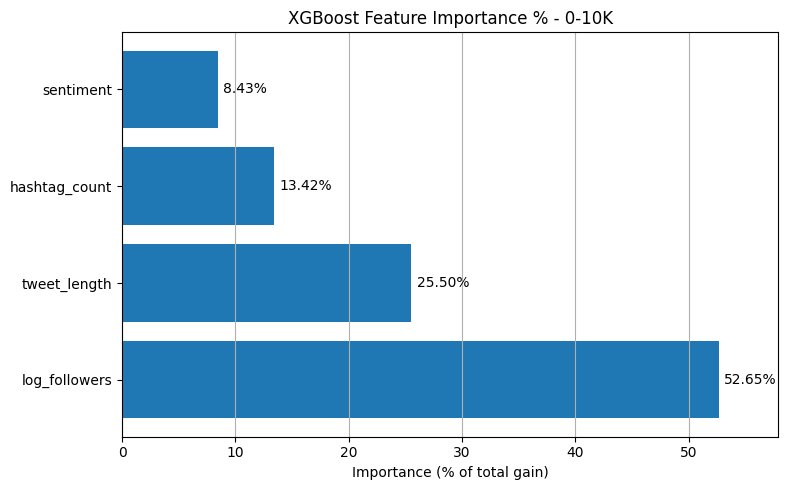


=== XGBoost Feature importance for bin 10K-100K ===

--- Normalized Feature Importance (percent of total gain) ---
tweet_length: 44.23%
log_followers: 31.52%
sentiment: 13.30%
hashtag_count: 10.95%


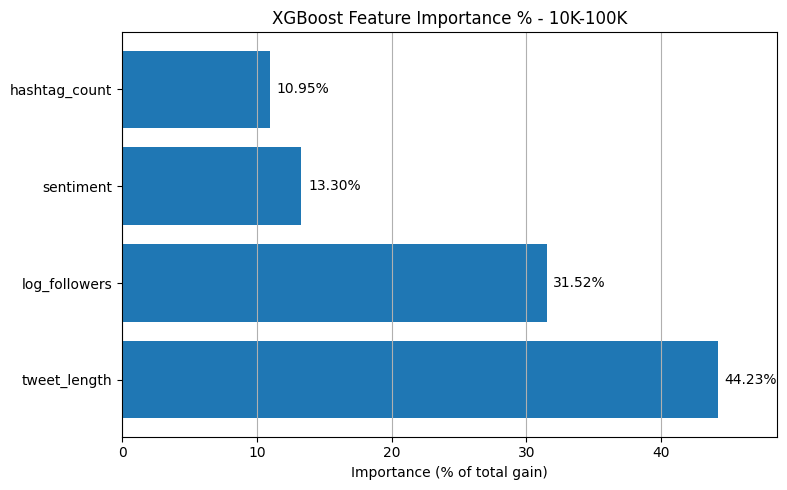


=== XGBoost Feature importance for bin 100K-1M ===

--- Normalized Feature Importance (percent of total gain) ---
tweet_length: 39.58%
log_followers: 22.29%
sentiment: 20.50%
hashtag_count: 17.63%


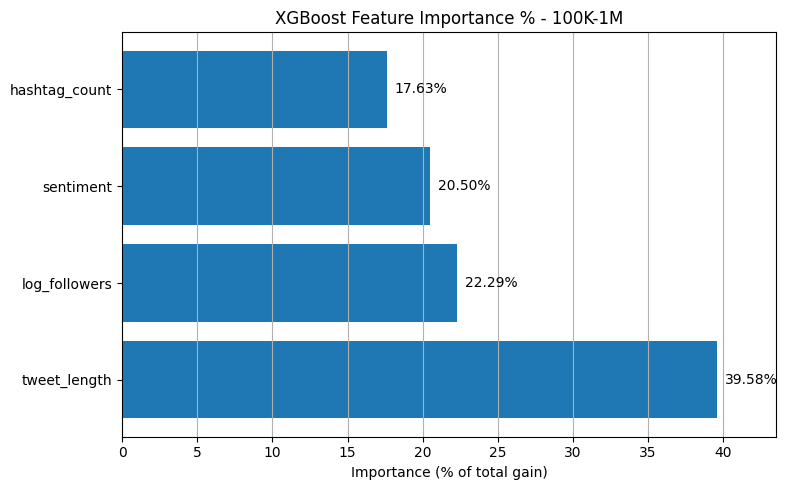


=== XGBoost Feature importance for bin 1M-10M ===

--- Normalized Feature Importance (percent of total gain) ---
log_followers: 38.97%
tweet_length: 28.49%
sentiment: 22.75%
hashtag_count: 9.80%


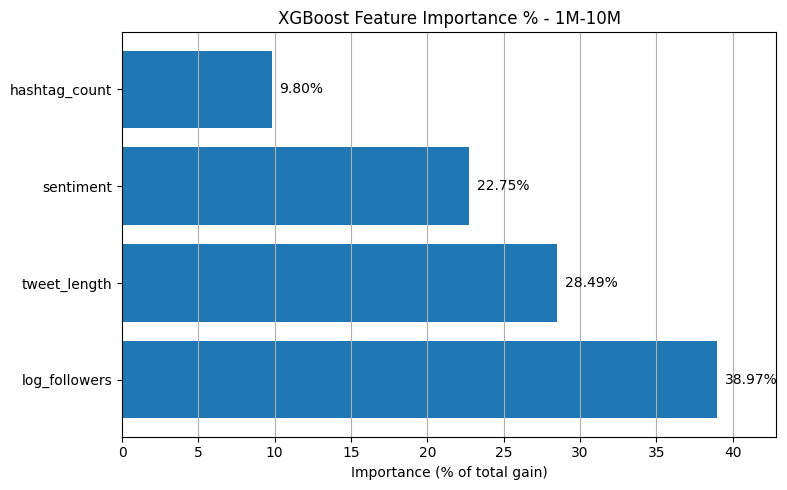


=== XGBoost Feature importance for bin 10M+ ===

--- Normalized Feature Importance (percent of total gain) ---
log_followers: 82.41%
tweet_length: 8.77%
hashtag_count: 5.42%
sentiment: 3.40%


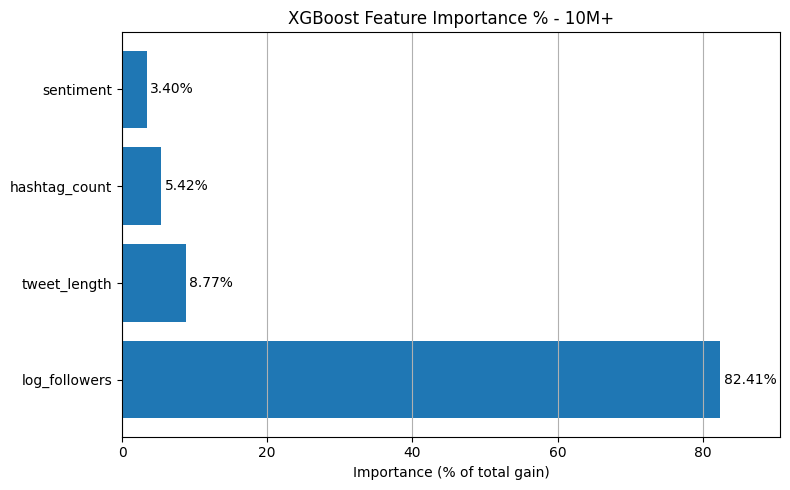

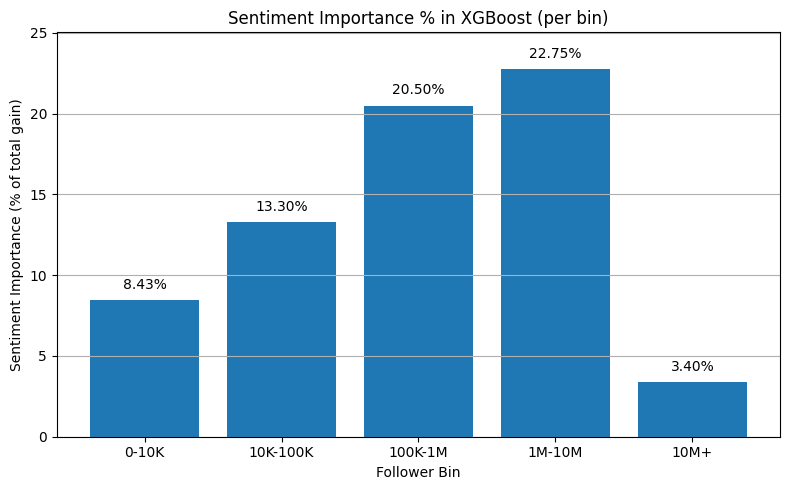

In [ ]:
#============================= XGBOOST PER-BIN FEATURE IMPORTANCE (PLOTS AS % BARS) =============================#

print("\n" + "="*80)
print("          XGBOOST PER-BIN FEATURE IMPORTANCE (PLOTS AS % BARS)")
print("="*80)

xgb_sentiment_importances = []

for bin_label in labels:
    model = trained_models.get(bin_label)
    if model is None:
        print(f"⚠️ No XGBoost model for bin {bin_label}")
        continue

    print(f"\n=== XGBoost Feature importance for bin {bin_label} ===")

    # Extract raw importance (gain)
    booster = model.get_booster()
    importance_dict = booster.get_score(importance_type='gain')

    # Compute total gain for this bin
    total_gain = sum(importance_dict.values())

    # Save sentiment importance for comparison (as %)
    sentiment_score = importance_dict.get('sentiment', 0)
    sentiment_pct = sentiment_score / total_gain * 100 if total_gain > 0 else 0
    xgb_sentiment_importances.append((bin_label, sentiment_pct))

    # Build data for plot — normalized %
    sorted_importance = sorted(importance_dict.items(), key=lambda x: x[1], reverse=True)

    feature_names = [f for f, _ in sorted_importance]
    feature_pct = [(score / total_gain * 100) if total_gain > 0 else 0 for _, score in sorted_importance]

    # Print table
    print(f"\n--- Normalized Feature Importance (percent of total gain) ---")
    for feature, pct in zip(feature_names, feature_pct):
        print(f"{feature}: {pct:.2f}%")

    # Plot — clean horizontal bar plot with %
    plt.figure(figsize=(8, 5))
    bars = plt.barh(feature_names, feature_pct)
    plt.title(f"XGBoost Feature Importance % - {bin_label}")
    plt.xlabel("Importance (% of total gain)")
    plt.xlim(0, max(feature_pct) * 1.1 if feature_pct else 1)  # add margin
    plt.grid(axis='x')

    # Add % labels on bars
    for bar in bars:
        width = bar.get_width()
        plt.text(width + 0.5, bar.get_y() + bar.get_height() / 2, f"{width:.2f}%", va='center')

    plt.tight_layout()
    plt.show()

#============================= SENTIMENT % PLOT ACROSS BINS =============================#

# Plot sentiment importance across bins (normalized %)
bins_plot = [b for b, _ in xgb_sentiment_importances]
scores_plot = [s for _, s in xgb_sentiment_importances]

plt.figure(figsize=(8, 5))
bars = plt.bar(bins_plot, scores_plot)
plt.title("Sentiment Importance % in XGBoost (per bin)")
plt.xlabel("Follower Bin")
plt.ylabel("Sentiment Importance (% of total gain)")
plt.ylim(0, max(scores_plot) * 1.1)  # add margin
plt.grid(axis='y')

# Add % labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.5, f"{height:.2f}%", ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()



          SHAP ANALYSIS — XGBOOST PER-BIN

=== SHAP analysis for bin 0-10K ===


100%|===================| 125363/125488 [12:15<00:00]       

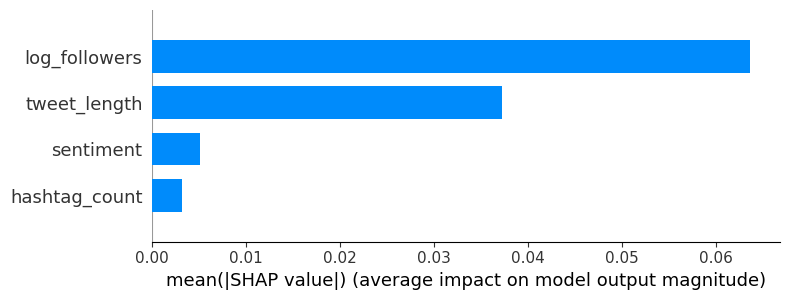

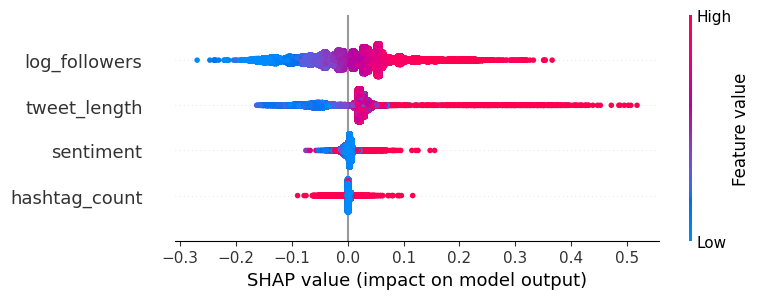


=== SHAP analysis for bin 10K-100K ===


 96%|=================== | 7041/7308 [00:24<00:00]       

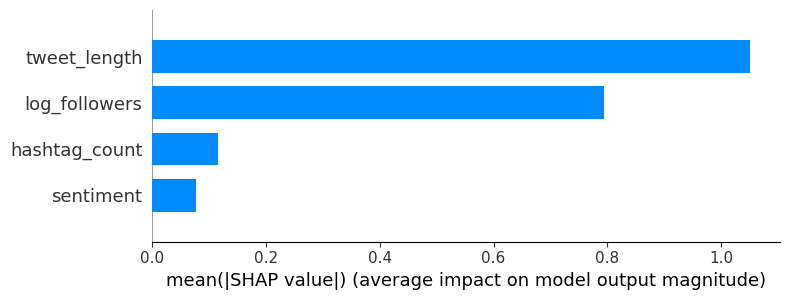

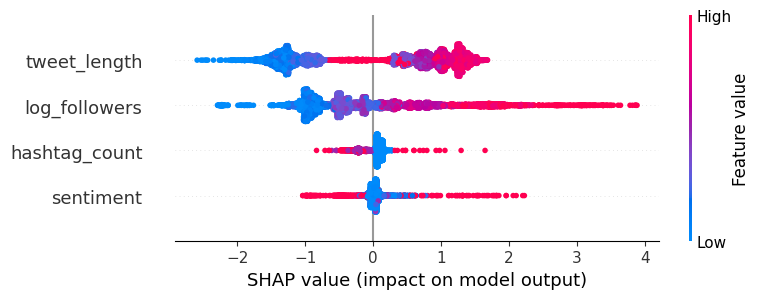


=== SHAP analysis for bin 100K-1M ===


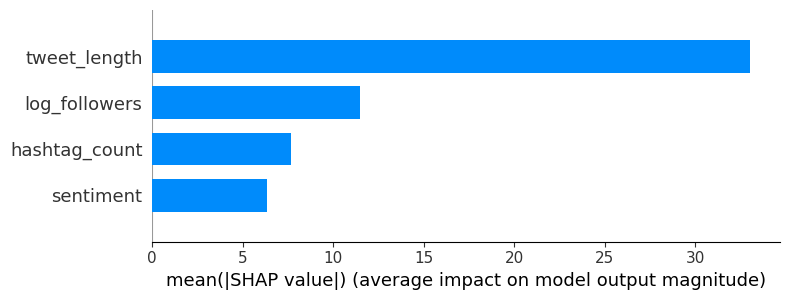

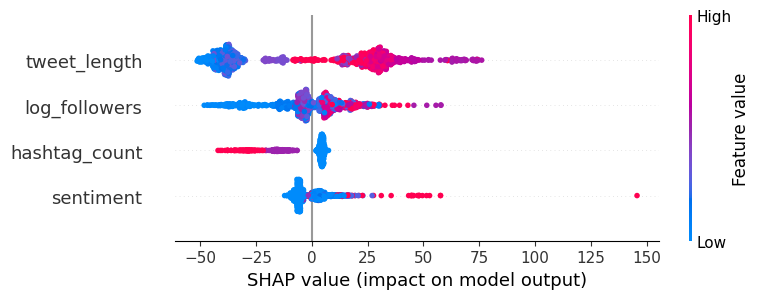


=== SHAP analysis for bin 1M-10M ===


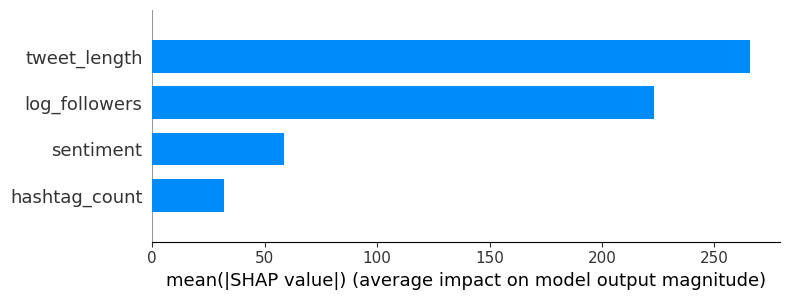

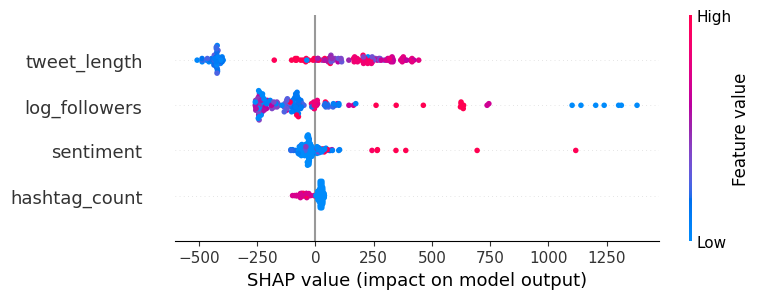


=== SHAP analysis for bin 10M+ ===


 98%|===================| 18240/18567 [00:52<00:00]       

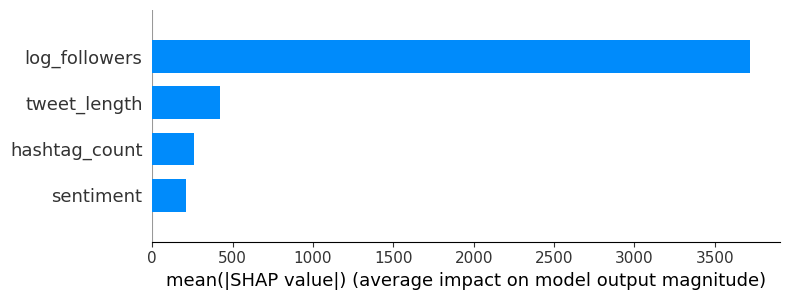

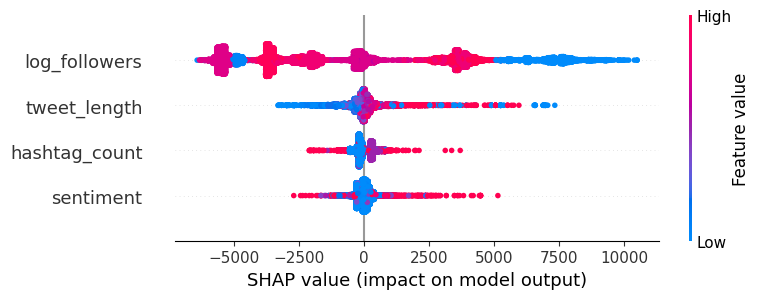

In [ ]:
#============================= SHAP ANALYSIS — XGBOOST PER-BIN =============================#

import shap

# Re-create popularity_bin — needed for SHAP block
bins = [0, 1e4, 1e5, 1e6, 1e7, np.inf]
labels = ['0-10K', '10K-100K', '100K-1M', '1M-10M', '10M+']
df['popularity_bin'] = pd.cut(df['followers_count'], bins=bins, labels=labels, right=False)
# Ensure features are present
df['log_followers'] = np.log1p(df['followers_count'])

print("\n" + "="*80)
print("          SHAP ANALYSIS — XGBOOST PER-BIN")
print("="*80)

# Feature names — your XGBoost uses:
features = ['log_followers', 'sentiment', 'tweet_length', 'hashtag_count']

for bin_label in labels:
    model = trained_models.get(bin_label)
    if model is None:
        print(f"⚠️ No XGBoost model for bin {bin_label}")
        continue

    print(f"\n=== SHAP analysis for bin {bin_label} ===")

    # Prepare data for this bin — same as in training
    group_df = df[df['popularity_bin'] == bin_label].copy()
    group_df = group_df[features + ['number_of_likes']].dropna()
    group_df = group_df[np.isfinite(group_df['number_of_likes'])]

    if len(group_df) < 50:
        print(f"⚠️ Skipping bin {bin_label} — too few rows ({len(group_df)})")
        continue

    X_bin = group_df[features]

    # Create SHAP explainer
    explainer = shap.Explainer(model, X_bin)

    # Compute SHAP values
    shap_values = explainer(X_bin)

    # GLOBAL importance: summary bar plot
    shap.summary_plot(shap_values, X_bin, plot_type="bar", show=True)

    # DETAILED summary plot (beeswarm)
    shap.summary_plot(shap_values, X_bin, show=True)



          DECISION TREE PER-GROUP FEATURE IMPORTANCE (PLOTS AS % BARS)

=== Decision Tree Feature Importance for group Group_0 ===

--- Normalized Feature Importance (percent of total importance) ---
sentiment: 90.72%
followers_count: 9.28%


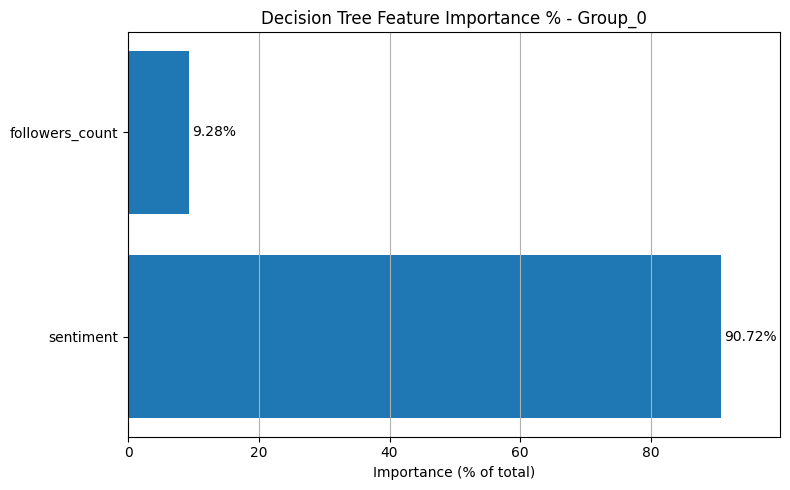


=== Decision Tree Feature Importance for group Group_1 ===

--- Normalized Feature Importance (percent of total importance) ---
followers_count: 52.00%
sentiment: 48.00%


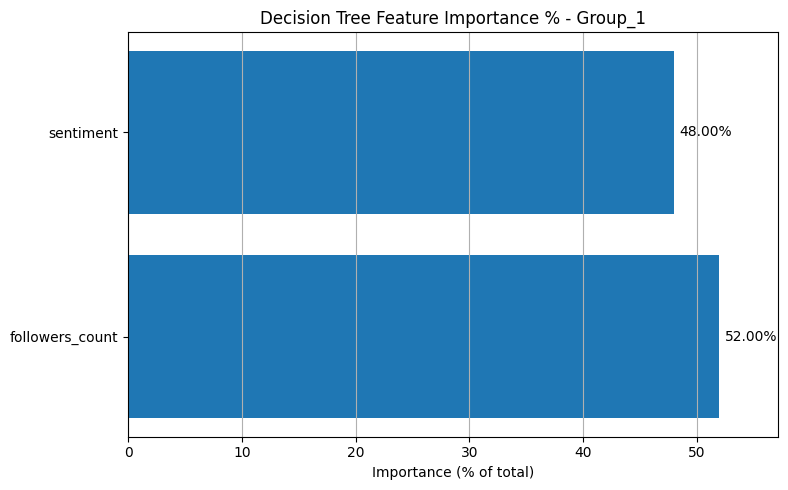


=== Decision Tree Feature Importance for group Group_2 ===

--- Normalized Feature Importance (percent of total importance) ---
followers_count: 63.18%
sentiment: 36.82%


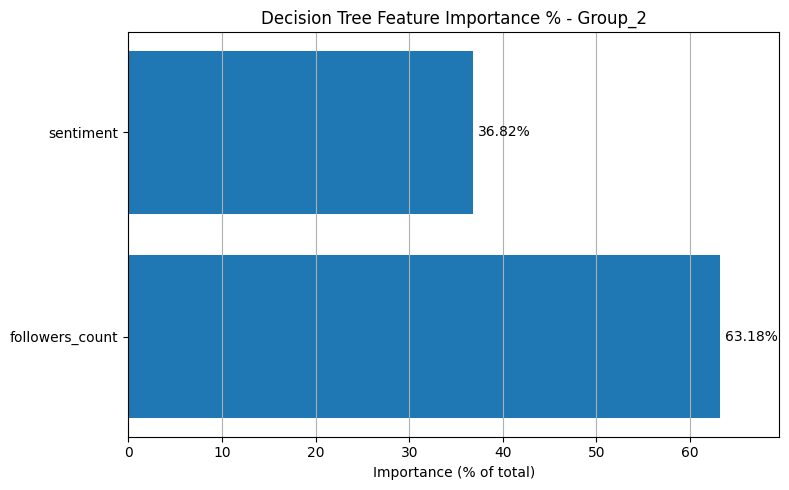


=== Decision Tree Feature Importance for group Group_3 ===

--- Normalized Feature Importance (percent of total importance) ---
followers_count: 59.93%
sentiment: 40.07%


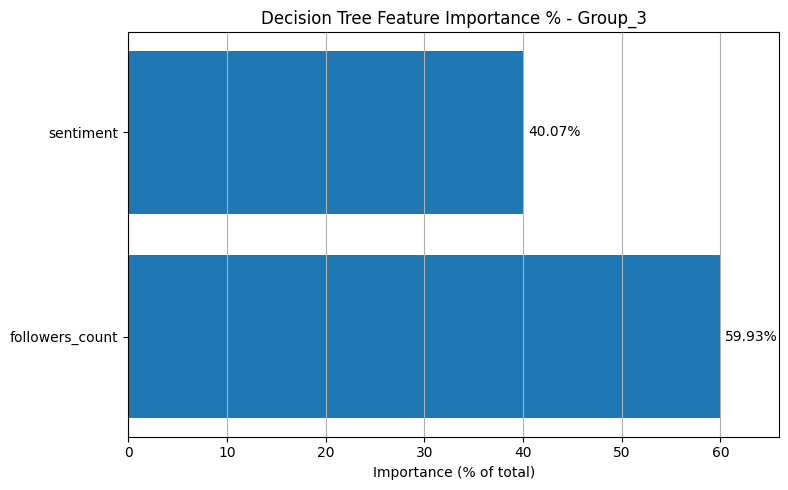


=== Decision Tree Feature Importance for group Group_4 ===

--- Normalized Feature Importance (percent of total importance) ---
followers_count: 97.08%
sentiment: 2.92%


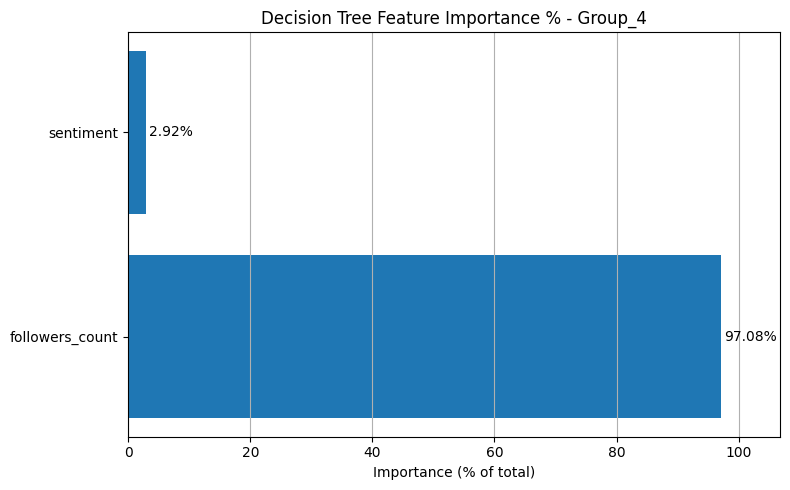


=== Decision Tree Feature Importance for group Group_5 ===

--- Normalized Feature Importance (percent of total importance) ---
sentiment: 51.15%
followers_count: 48.85%


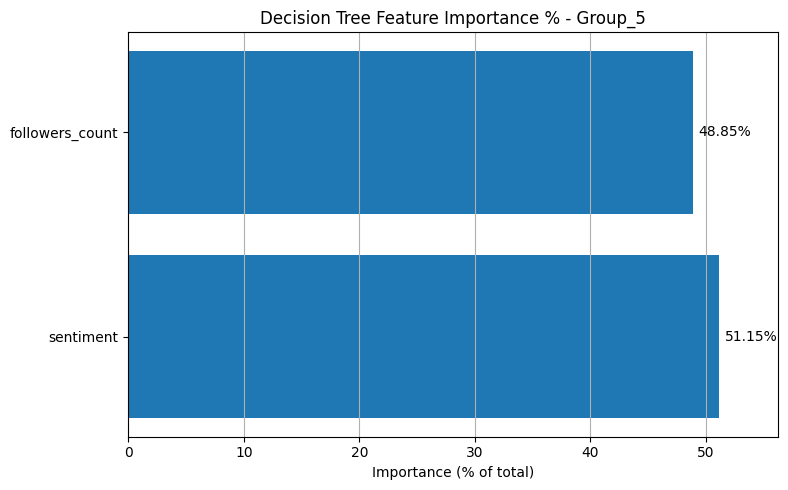


=== Decision Tree Feature Importance for group Group_6 ===

--- Normalized Feature Importance (percent of total importance) ---
followers_count: 88.69%
sentiment: 11.31%


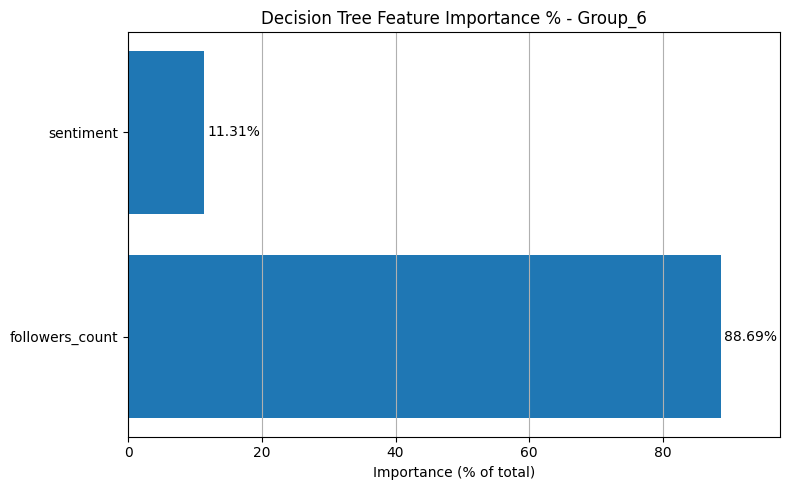


=== Decision Tree Feature Importance for group Group_7a ===

--- Normalized Feature Importance (percent of total importance) ---
followers_count: 91.15%
sentiment: 8.85%


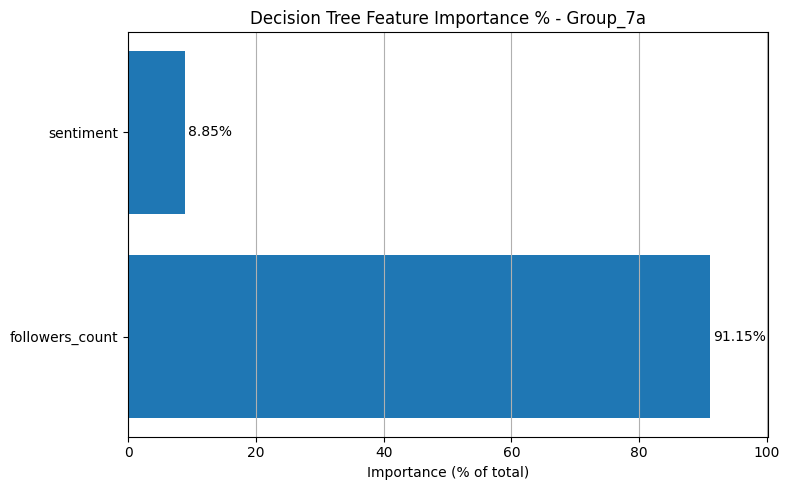


=== Decision Tree Feature Importance for group Group_7b ===

--- Normalized Feature Importance (percent of total importance) ---
followers_count: 93.18%
sentiment: 6.82%


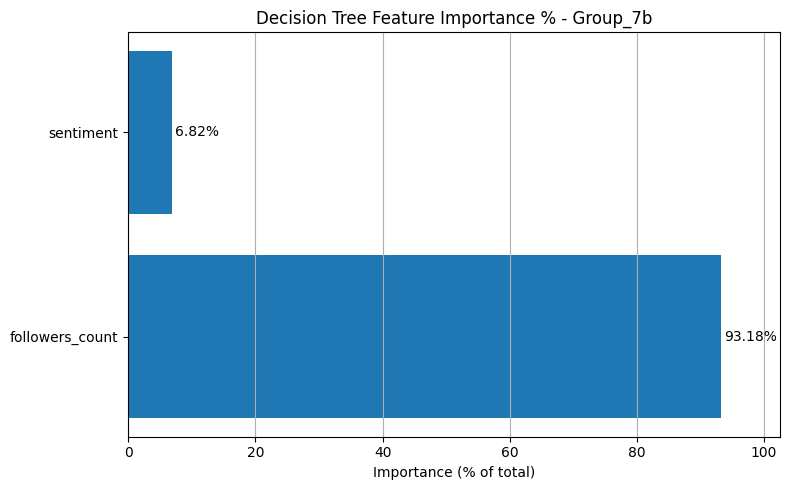


=== Decision Tree Feature Importance for group Group_7c1 ===

--- Normalized Feature Importance (percent of total importance) ---
sentiment: 100.00%
followers_count: 0.00%


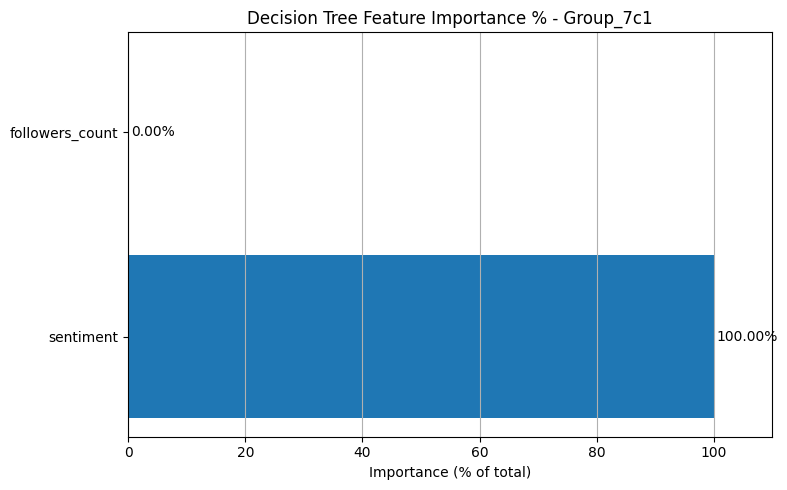


=== Decision Tree Feature Importance for group Group_7c2 ===

--- Normalized Feature Importance (percent of total importance) ---
followers_count: 87.20%
sentiment: 12.80%


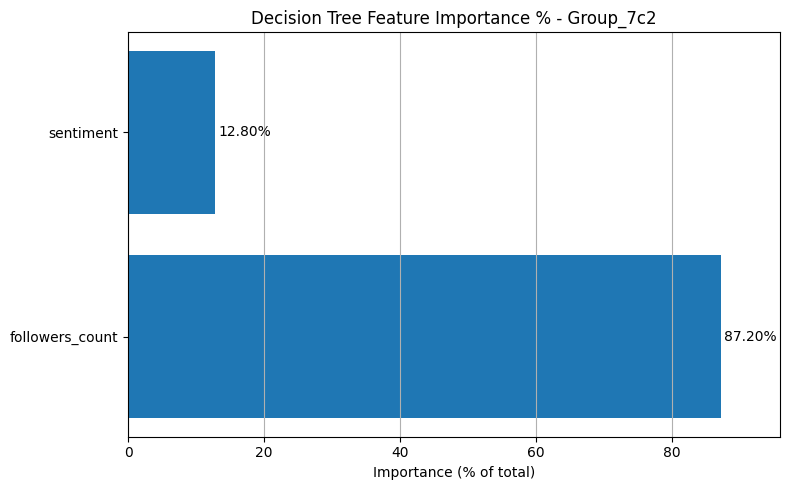

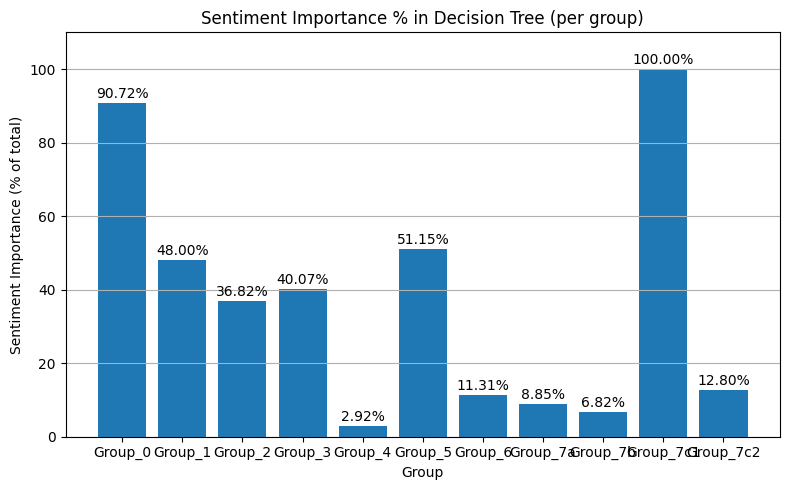

In [ ]:
#============================= DT PER-GROUP FEATURE IMPORTANCE (PLOTS AS % BARS) =============================#
import matplotlib.pyplot as plt
print("\n" + "="*80)
print("          DECISION TREE PER-GROUP FEATURE IMPORTANCE (PLOTS AS % BARS)")
print("="*80)

dt_sentiment_importances = []

for group_name in all_group_names:
    if '7' in group_name and len(group_name) > 7:
        group_id = group_name.split('_')[1]
    else:
        group_id = int(group_name.split('_')[1])

    model_info = trained_dt_models.get(group_id)
    if model_info is None:
        print(f"⚠️ No Decision Tree model for group {group_id}")
        continue

    dt_model = model_info['model']
    feature_columns = model_info['feature_columns']

    importances = dt_model.feature_importances_
    total_importance = np.sum(importances)

    # Save sentiment importance for comparison (as %)
    try:
        sentiment_idx = feature_columns.index('sentiment')
        sentiment_score = importances[sentiment_idx]
        sentiment_pct = sentiment_score / total_importance * 100 if total_importance > 0 else 0
    except ValueError:
        sentiment_pct = 0

    dt_sentiment_importances.append((group_name, sentiment_pct))

    # Prepare sorted feature importance
    sorted_indices = np.argsort(importances)[::-1]
    sorted_features = [feature_columns[i] for i in sorted_indices]
    sorted_importance_pct = [
        (importances[i] / total_importance * 100) if total_importance > 0 else 0
        for i in sorted_indices
    ]

    # Print table
    print(f"\n=== Decision Tree Feature Importance for group {group_name} ===")
    print(f"\n--- Normalized Feature Importance (percent of total importance) ---")
    for feature, pct in zip(sorted_features, sorted_importance_pct):
        print(f"{feature}: {pct:.2f}%")

    # Plot — clean horizontal bar plot with %
    plt.figure(figsize=(8, 5))
    bars = plt.barh(sorted_features, sorted_importance_pct)
    plt.title(f"Decision Tree Feature Importance % - {group_name}")
    plt.xlabel("Importance (% of total)")
    plt.xlim(0, max(sorted_importance_pct) * 1.1 if sorted_importance_pct else 1)  # add margin
    plt.grid(axis='x')

    # Add % labels on bars
    for bar in bars:
        width = bar.get_width()
        plt.text(width + 0.5, bar.get_y() + bar.get_height() / 2, f"{width:.2f}%", va='center')

    plt.tight_layout()
    plt.show()

#============================= SENTIMENT % PLOT ACROSS GROUPS =============================#

# Plot sentiment importance across groups (normalized %)
groups_plot = [g for g, _ in dt_sentiment_importances]
scores_plot = [s for _, s in dt_sentiment_importances]

plt.figure(figsize=(8, 5))
bars = plt.bar(groups_plot, scores_plot)
plt.title("Sentiment Importance % in Decision Tree (per group)")
plt.xlabel("Group")
plt.ylabel("Sentiment Importance (% of total)")
plt.ylim(0, max(scores_plot) * 1.1)  # add margin
plt.grid(axis='y')

# Add % labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.5, f"{height:.2f}%", ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()



          DECISION TREE PER-GROUP SHAP ANALYSIS (NORMALIZED %)

=== SHAP Summary for Decision Tree - Group Group_0 ===


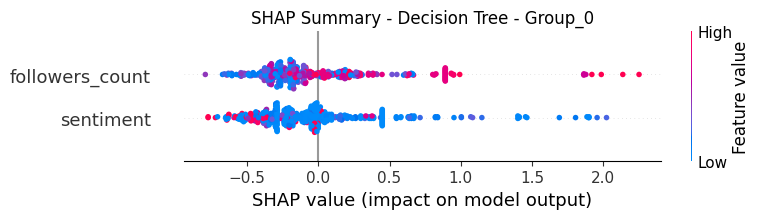

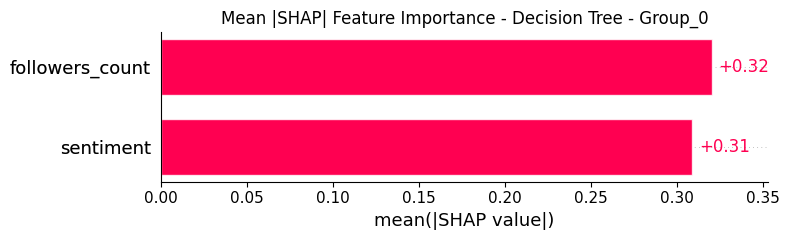


--- Normalized SHAP Importance (percent of total) for group Group_0 ---
followers_count: 50.89%
sentiment: 49.11%

=== SHAP Summary for Decision Tree - Group Group_1 ===


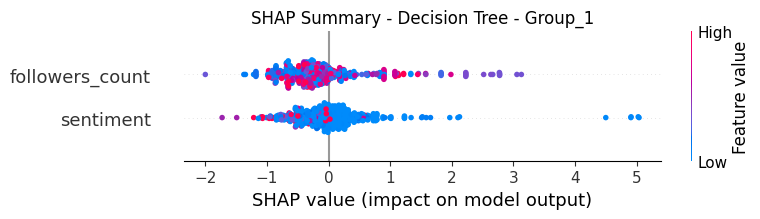

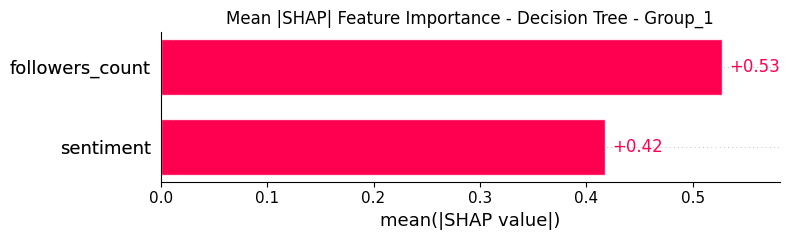


--- Normalized SHAP Importance (percent of total) for group Group_1 ---
followers_count: 55.82%
sentiment: 44.18%

=== SHAP Summary for Decision Tree - Group Group_2 ===


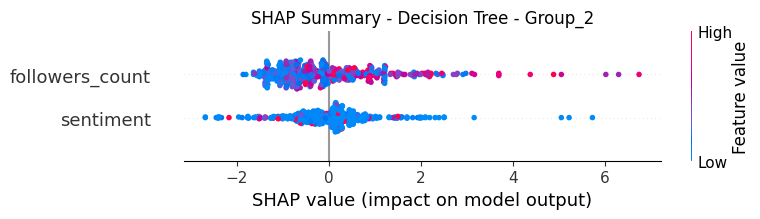

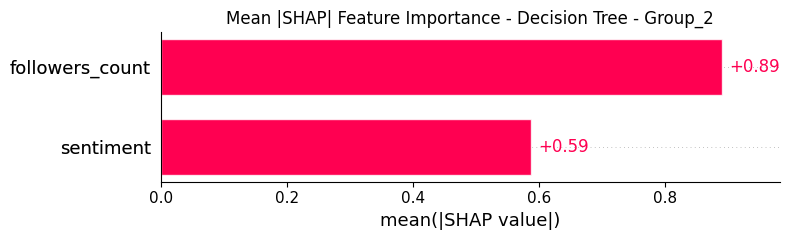


--- Normalized SHAP Importance (percent of total) for group Group_2 ---
followers_count: 60.25%
sentiment: 39.75%

=== SHAP Summary for Decision Tree - Group Group_3 ===


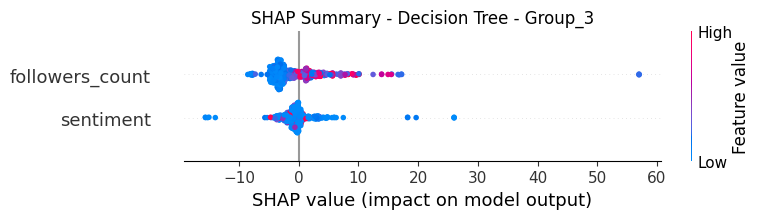

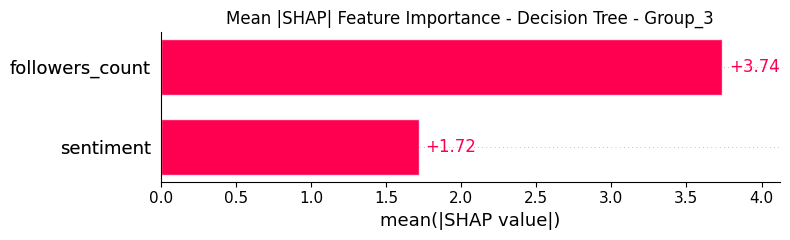


--- Normalized SHAP Importance (percent of total) for group Group_3 ---
followers_count: 68.51%
sentiment: 31.49%

=== SHAP Summary for Decision Tree - Group Group_4 ===


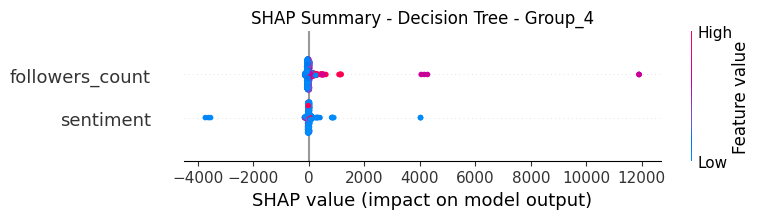

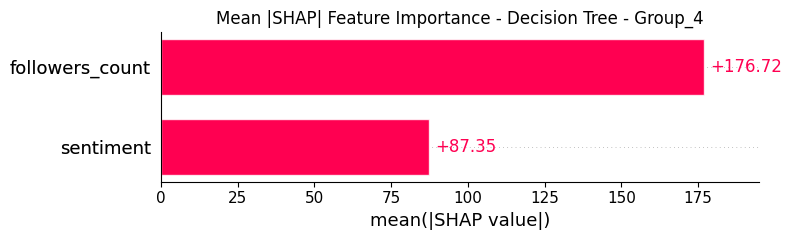


--- Normalized SHAP Importance (percent of total) for group Group_4 ---
followers_count: 66.92%
sentiment: 33.08%

=== SHAP Summary for Decision Tree - Group Group_5 ===


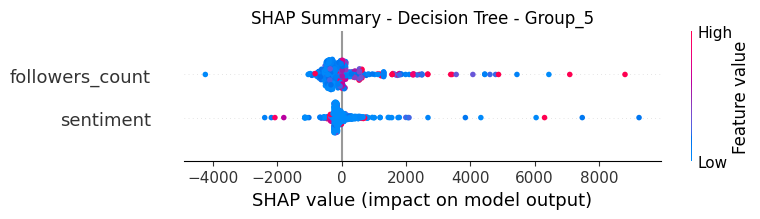

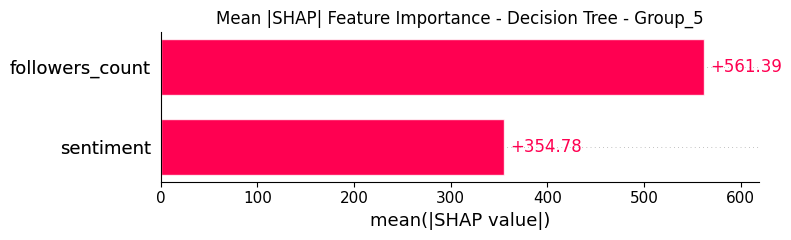


--- Normalized SHAP Importance (percent of total) for group Group_5 ---
followers_count: 61.28%
sentiment: 38.72%

=== SHAP Summary for Decision Tree - Group Group_6 ===


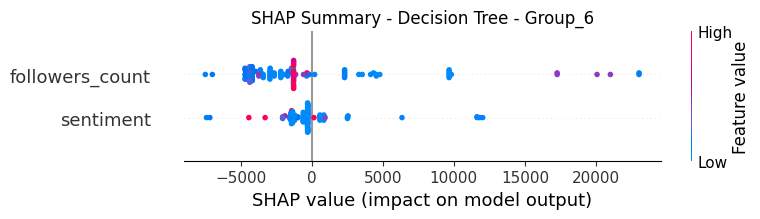

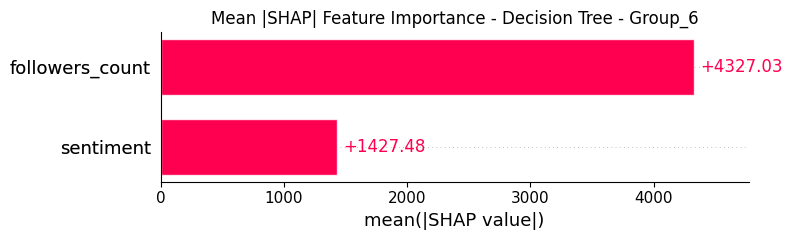


--- Normalized SHAP Importance (percent of total) for group Group_6 ---
followers_count: 75.19%
sentiment: 24.81%

=== SHAP Summary for Decision Tree - Group Group_7a ===


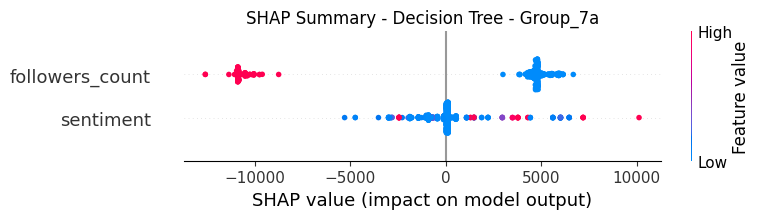

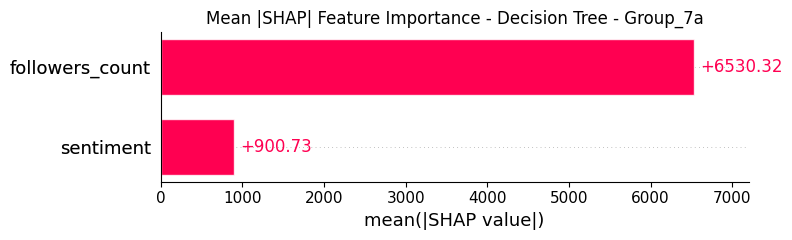


--- Normalized SHAP Importance (percent of total) for group Group_7a ---
followers_count: 87.88%
sentiment: 12.12%

=== SHAP Summary for Decision Tree - Group Group_7b ===


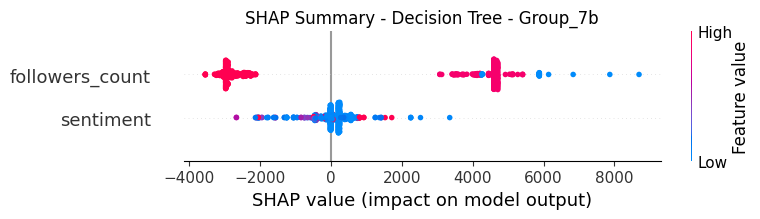

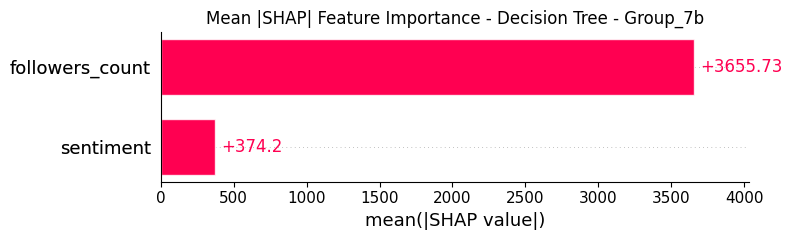


--- Normalized SHAP Importance (percent of total) for group Group_7b ---
followers_count: 90.71%
sentiment: 9.29%

=== SHAP Summary for Decision Tree - Group Group_7c1 ===


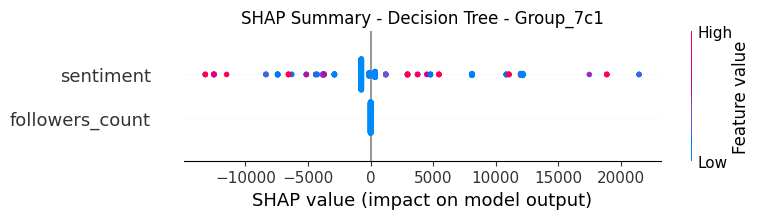

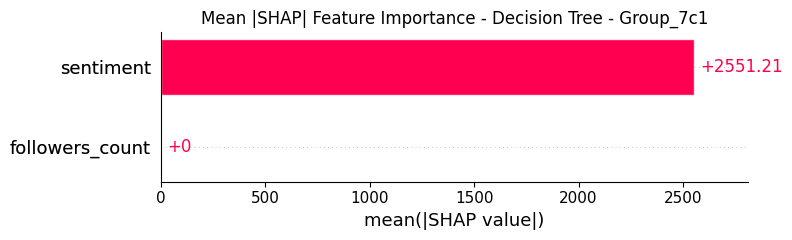


--- Normalized SHAP Importance (percent of total) for group Group_7c1 ---
sentiment: 100.00%
followers_count: 0.00%

=== SHAP Summary for Decision Tree - Group Group_7c2 ===


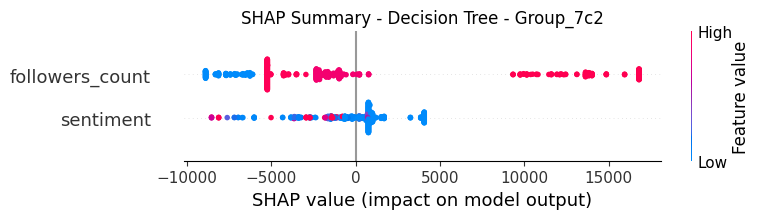

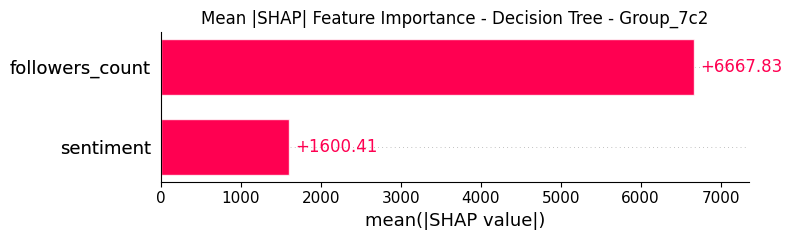


--- Normalized SHAP Importance (percent of total) for group Group_7c2 ---
followers_count: 80.64%
sentiment: 19.36%


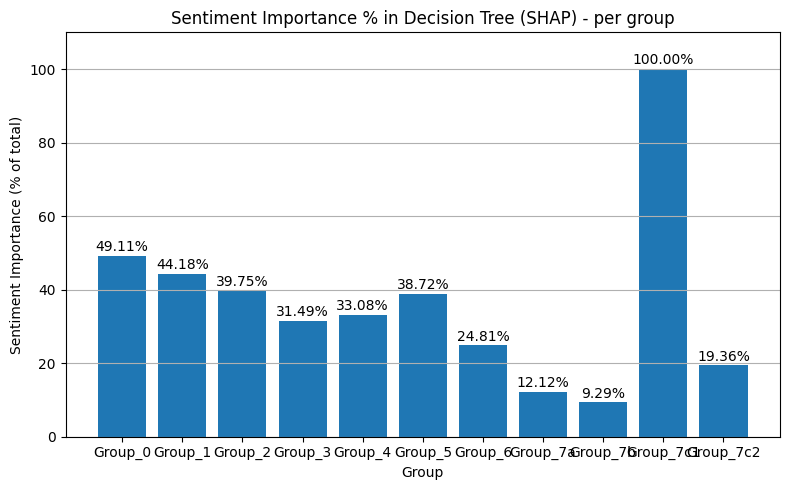

In [ ]:
#============================= DECISION TREE PER-GROUP SHAP ANALYSIS + NORMALIZED % =============================#

import shap
import matplotlib.pyplot as plt

# Use TreeExplainer for Decision Tree Regressor (fast and native support)
explainer_type = shap.Explainer  # SHAP auto detects correct type

print("\n" + "="*80)
print("          DECISION TREE PER-GROUP SHAP ANALYSIS (NORMALIZED %)")
print("="*80)

# Optional: save sentiment importance per group for final cross-group plot
dt_shap_sentiment_importances = []

for group_name in all_group_names:
    if '7' in group_name and len(group_name) > 7:
        group_id = group_name.split('_')[1]
    else:
        group_id = int(group_name.split('_')[1])

    model_info = trained_dt_models.get(group_id)
    if model_info is None:
        print(f"⚠️ No Decision Tree model for group {group_id}")
        continue

    dt_model = model_info['model']
    feature_columns = model_info.get('feature_columns', ['followers_count', 'sentiment'])

    # Rebuild small dataframe to feed explainer (SHAP wants original feature matrix)
    df_group = df_clean[df_clean['group'] == group_name].copy()
    features_df = create_features_for_modeling(df_group)
    X = features_df[feature_columns]

    # Subsample for speed if large
    X_sample = X.sample(min(500, len(X)), random_state=42)

    # Build SHAP explainer
    explainer = explainer_type(dt_model, X_sample)

    # Compute SHAP values
    shap_values = explainer(X_sample)

    print(f"\n=== SHAP Summary for Decision Tree - Group {group_name} ===")

    # 1️⃣ Beeswarm plot
    shap.plots.beeswarm(shap_values, show=False)
    plt.title(f"SHAP Summary - Decision Tree - {group_name}")
    plt.tight_layout()
    plt.show()

    # 2️⃣ Bar plot (mean |SHAP| per feature)
    shap.plots.bar(shap_values, show=False)
    plt.title(f"Mean |SHAP| Feature Importance - Decision Tree - {group_name}")
    plt.tight_layout()
    plt.show()

    # 3️⃣ Normalized % table
    mean_abs_shap = np.abs(shap_values.values).mean(axis=0)
    total_mean_abs_shap = np.sum(mean_abs_shap)
    importance_pct = mean_abs_shap / total_mean_abs_shap * 100

    shap_importance_df = pd.DataFrame({
        'feature': feature_columns,
        'mean_abs_shap': mean_abs_shap,
        'importance_pct': importance_pct
    }).sort_values(by='importance_pct', ascending=False)

    print(f"\n--- Normalized SHAP Importance (percent of total) for group {group_name} ---")
    for _, row in shap_importance_df.iterrows():
        print(f"{row['feature']}: {row['importance_pct']:.2f}%")

    # Save sentiment % for later plot
    try:
        sentiment_pct = shap_importance_df[shap_importance_df['feature'] == 'sentiment']['importance_pct'].values[0]
    except IndexError:
        sentiment_pct = 0.0

    dt_shap_sentiment_importances.append((group_name, sentiment_pct))

#============================= SENTIMENT % PLOT ACROSS GROUPS (SHAP) =============================#

groups_plot = [g for g, _ in dt_shap_sentiment_importances]
scores_plot = [s for _, s in dt_shap_sentiment_importances]

plt.figure(figsize=(8, 5))
bars = plt.bar(groups_plot, scores_plot)
plt.title("Sentiment Importance % in Decision Tree (SHAP) - per group")
plt.xlabel("Group")
plt.ylabel("Sentiment Importance (% of total)")
plt.ylim(0, max(scores_plot) * 1.1)  # add margin
plt.grid(axis='y')

# Add % labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.5, f"{height:.2f}%", ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()
